In [1]:
%load_ext autoreload
%autoreload 2
from vocDataGen import Generator
import pickle
from visualization import visualization
import matplotlib.pyplot as plt
from nms import getROI, nmsWrapper, ROILayer, getROILabel
import numpy as np
from keras.layers import Flatten, Dense, Reshape, Dropout, Input
from buildModel import buildModel, FRCNN
from RPN_feeder_loss import pred2bbox

Using TensorFlow backend.


In [2]:
with open('train.pickle', 'rb') as f:
    data = pickle.load(f)
gen = Generator(data[:100], [800, 600], 64, useAugmentation=False, angle=45, shift=10,
                 basesize=16, isSample=True,)


In [3]:
path = './allModels/epoch:5_rpnMetric1:0.987_rpnMetric2:0.444_clsMetric1:0.678_clsMetric2:0.605'
frcnn = FRCNN(21, path, True)

/home/johnsmith/fsk_env/lib/python3.5/site-packages/keras/engine/topology.py:1539: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'RPNScores/Reshape:0' shape=(?, ?, 1) dtype=float32>, <tf.Tensor 'RPNRegression/Reshape:0' shape=(?, ?, 4) dtype=float32>, <tf.Tensor 'clsScore/Softmax:0' shape=(?, 21) dtype=float32>, <tf.Tensor 'RPNRegression/Reshape:0' shape=(?, ?, 4) dtype=float32>]
  ' Found: ' + str(self.outputs))


In [12]:
image, labels, targetBBoxes, bboxes = next(gen)

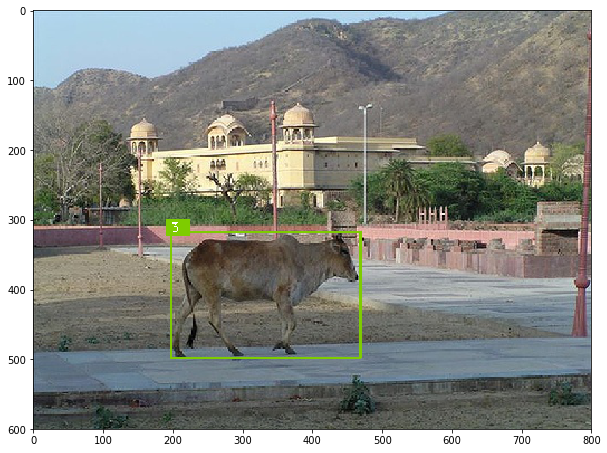

In [13]:
visImage = visualization(np.squeeze(image), bboxes[0, :, :4], bboxes[0, :, -1])#?????
fig2 = plt.figure(figsize = (10,10)) # create a 5 x 5 figure 
ax3 = fig2.add_subplot(111)
ax3.imshow(visImage)

show results of rpn

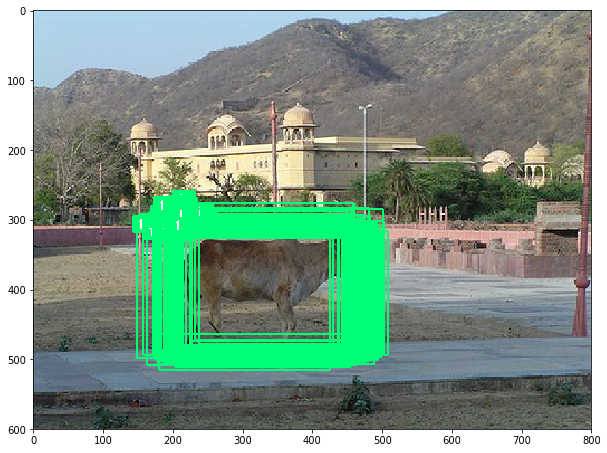

In [14]:
predScore, predRegression = frcnn.rpn.predict(image)
roi, gtLabels, tgBBoxes = ROILayer('train', None)(predScore, predRegression, gen.dims, 120, gtBBoxes=bboxes[0, :, :4],
          gtLabels=np.expand_dims(bboxes[0, :, -1], axis=-1), isSample=False) #just for compare
visImage = visualization(np.squeeze(image), roi, [1]*roi.shape[0])#?????
fig2 = plt.figure(figsize = (10,10)) # create a 5 x 5 figure 
ax3 = fig2.add_subplot(111)
ax3.imshow(visImage)

results of clsNet

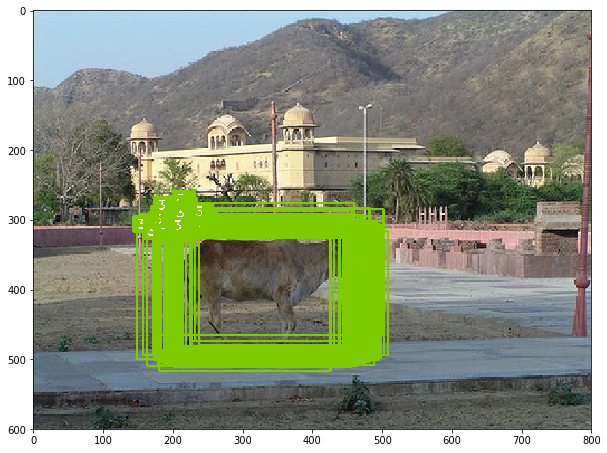

In [15]:
batchROI = np.round(np.expand_dims(roi, axis=0) / 16)
finalScores, finalRegression = frcnn.clsNet.predict_on_batch([image, batchROI])
finalRegression = np.reshape(finalRegression, [-1, 21, 4])
labels = np.argmax(finalScores, axis=-1)

indices = np.where(labels>0)[0]
finalBBoxes = pred2bbox(finalRegression[indices, labels[indices], :], roi[indices])
#nmsIndices = nmsWrapper(0.5)(finalBBoxes)
visImage = visualization(np.squeeze(image), finalBBoxes, labels[indices])#?????
fig2 = plt.figure(figsize = (10,10)) # create a 5 x 5 figure 
ax3 = fig2.add_subplot(111)
ax3.imshow(visImage)

results of faster rcnn(it contains nms)

In [18]:
selectedLabel, selectedBBoxes = frcnn.predict(image, threshold=0.7)


(0,) (200, 21, 4)
(0,) (200, 21, 4)
(113,) (200, 21, 4)
(0,) (1,)
(0,) (200, 21, 4)
(0,) (200, 21, 4)
(0,) (200, 21, 4)
(0,) (200, 21, 4)
(0,) (200, 21, 4)
(0,) (200, 21, 4)
(0,) (200, 21, 4)
(0,) (200, 21, 4)
(0,) (200, 21, 4)
(0,) (200, 21, 4)
(0,) (200, 21, 4)
(0,) (200, 21, 4)
(0,) (200, 21, 4)
(0,) (200, 21, 4)
(0,) (200, 21, 4)
(0,) (200, 21, 4)
(0,) (200, 21, 4)


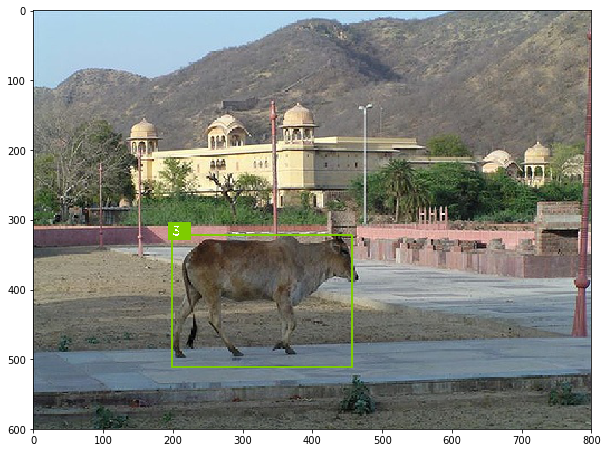

In [19]:
visImage = visualization(np.squeeze(image), selectedBBoxes, selectedLabel)#?????
fig2 = plt.figure(figsize = (10,10)) # create a 5 x 5 figure 
ax3 = fig2.add_subplot(111)
ax3.imshow(visImage)